In [1]:
import torch
import torchvision

import torch.utils.tensorboard as tb

from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd

LABEL_NAMES = {'background':0, 'kart':1, 'pickup':2, 'nitro':3, 'bomb':4, 'projectile':5}

LABEL_=['background','kart','pickup','nitro','bomb','projectile']

## Reading Data

In [0]:
# upload the data and unzip it. You will see data/ with train/ and valid/. 
!unzip supertux_classification_trainval.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/valid/01459.jpg    
  inflating: data/valid/07634.jpg    
  inflating: data/valid/03796.jpg    
  inflating: data/valid/01876.jpg    
  inflating: data/valid/04080.jpg    
  inflating: data/valid/06760.jpg    
  inflating: data/valid/01166.jpg    
  inflating: data/valid/00688.jpg    
  inflating: data/valid/05105.jpg    
  inflating: data/valid/04383.jpg    
  inflating: data/valid/04247.jpg    
  inflating: data/valid/06901.jpg    
  inflating: data/valid/04474.jpg    
  inflating: data/valid/06578.jpg    
  inflating: data/valid/08029.jpg    
  inflating: data/valid/04938.jpg    
  inflating: data/valid/03360.jpg    
  inflating: data/valid/05495.jpg    
  inflating: data/valid/02161.jpg    
  inflating: data/valid/02457.jpg    
  inflating: data/valid/03629.jpg    
  inflating: data/valid/03033.jpg    
  inflating: data/valid/00973.jpg    
  inflating: data/valid/05319.jpg    
  inflating: data/valid/07926.jpg    

## Defining Torch Dataset

In [2]:
class SuperTuxDataset(Dataset):
    def __init__(self, image_path,data_transforms=None):
        """
        Your code here
        Hint: Use the python csv library to parse labels.csv
        
        """
        labels = pd.read_csv(image_path+'/'+'labels.csv')
        self.image_path = image_path
        self.files = labels.iloc[:,0]
        self.labels = labels['label'].map(LABEL_NAMES)
        self.track = labels.iloc[:,2]
        # raise NotImplementedError('SuperTuxDataset.__init__')

    def __len__(self):
        """
        Your code here
        """
        return self.labels.shape[0]
        # raise NotImplementedError('SuperTuxDataset.__len__')

    def __getitem__(self, idx):
        """
        Your code here
        return a tuple: img, label
        """
        img = Image.open(self.image_path + '/'+self.files.iloc[idx])
        img = transforms.ToTensor()(img)
        return (img,self.labels[idx])
        # raise NotImplementedError('SuperTuxDataset.__getitem__')


The following utility visualizes the data, optionally, as a sanity check for your implementation of the dataset class. Call visualize_data() after setting the correct variables inside this code snippet. 

In [3]:

def visualize_data():

    Path_to_your_data= 'data/train'
    dataset = SuperTuxDataset(image_path=Path_to_your_data)

    f, axes = plt.subplots(3, len(LABEL_NAMES))

    counts = [0]*len(LABEL_NAMES)

    for img, label in dataset:
        c = counts[label]

        if c < 3:
            ax = axes[c][label]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(LABEL_[label])
            counts[label] += 1
        
        if sum(counts) >= 3 * len(LABEL_NAMES):
            break

    plt.show()

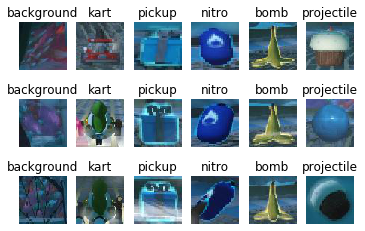

In [4]:
visualize_data()

## Defining Model Architecture and Loss

In [5]:

class ClassificationLoss(torch.nn.Module):
    def forward(self, input, target):
        """
        Your code here
        Compute mean(-log(softmax(input)_label))
        @input:  torch.Tensor((B,C)), where B = batch size, C = number of classes
        @target: torch.Tensor((B,), dtype=torch.int64)
        @return:  torch.Tensor((,))
        Hint: Don't be too fancy, this is a one-liner
        """
        B = target.shape[0]
        log_Proba = torch.zeros(B,)
        softmax = torch.nn.functional.softmax(input,dim=1)
        for i in range(B):
            log_Proba[i] = -torch.log(softmax[i,target[i]])
        return log_Proba.mean()


class CNNClassifier(torch.nn.Module):
    def __init__(self):
        """
        Your code here
        """
        super(CNNClassifier,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,32, 3,1)
        self.conv2 = torch.nn.Conv2d(32,64,3,1)
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.dropout2 = torch.nn.Dropout2d(0.5)
        self.fc1 = torch.nn.Linear(57600,128)
        self.fc2 = torch.nn.Linear(128,6)
        raise NotImplementedError('CNNClassifier.__init__')

    def forward(self, x):
        """
        Your code here
        @x: torch.Tensor((B,3,64,64))
        @return: torch.Tensor((B,6))
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x 
        raise NotImplementedError('CNNClassifier.forward')


In [6]:
from torch import save
from torch import load
from os import path

def save_model(model):
    if isinstance(model, CNNClassifier):
        return save(model.state_dict(), path.join(path.dirname(path.abspath("__file__")), 'cnn.th'))
    
    raise ValueError("model type '%s' not supported!"%str(type(model)))


def load_model():
    r = CNNClassifier()
    r.load_state_dict(load(path.join(path.dirname(path.abspath("__file__")), 'cnn.th'), map_location='cpu'))
    return r


## Tensorboard logging

In [7]:

def test_logging(train_logger, valid_logger):

    """
    Your code here.
    Finish logging the dummy loss and accuracy
    Log the loss every iteration, the accuracy only after each epoch
    Make sure to set global_step correctly, for epoch=0, iteration=0: global_step=0
    Call the loss 'loss', and accuracy 'accuracy' (no slash or other namespace)
    """

    # This is a strongly simplified training loop
    global_steps= 0 
    for epoch in range(10):
        torch.manual_seed(epoch)
        for iteration in range(20):
            dummy_train_loss = 0.9**(epoch+iteration/20.)
            dummy_train_accuracy = epoch/10. + torch.randn(10)
            train_logger.add_scalar('train/loss',dummy_train_loss,global_step = global_steps )
            global_steps += 1
            
            # raise NotImplementedError('Log the training loss')
        train_logger.add_scalar('train/accuracy',dummy_train_accuracy.mean(),global_step = global_steps)
        # raise NotImplementedError('Log the training accuracy')
        torch.manual_seed(epoch)
        for iteration in range(10):
            dummy_validation_accuracy = epoch / 10. + torch.randn(10)
        valid_logger.add_scalar('test/accuracy',dummy_validation_accuracy.mean(),global_step = global_steps)
        # raise NotImplementedError('Log the validation accuracy')


After implementing `test_logging()`, call it below. This should produce some plots on your tensorboard.

In [2]:
%load_ext tensorboard

In [3]:
%reload_ext tensorboard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
ROOT_LOG_DIR = './logdir'


In [4]:
%tensorboard --logdir {ROOT_LOG_DIR} #Launch tensorboard

In [20]:
!kill 46518

In [15]:
train_logger = tb.SummaryWriter(path.join('./logdir', 'train'))
valid_logger = tb.SummaryWriter(path.join('./logdir', 'test'))
test_logging(train_logger, valid_logger)

**Training and evaluation utility functions** 

Here are some implementations of useful functions for training and evaluating your models. Read these carefully. You may need to make some obvious edits before these will work.

In [78]:

import torch.nn.functional as F
import torchvision.transforms as TF

def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)

def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(6)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))
    
    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)
    
    axis.get_xaxis().set_visible(False)

def visualize_predictions():
  
    model = load_model()
    model.eval()

    validation_image_path='data/valid' #enter the path 

    dataset = SuperTuxDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img, label = dataset[idx]
        preds = predict(model, img[None], device='cpu').detach().cpu().numpy()

        axes[0, i].imshow(TF.ToPILImage()(img))
        axes[0, i].axis('off')
        draw_bar(axes[1, i], preds[0], LABEL_ if i == 0 else None)

    plt.show()

IndentationError: expected an indented block (<ipython-input-78-153ed9e24d0d>, line 10)

## Training models

The `load_data` utility below uses your implementation of the dataset class above to provide a helper function that might be useful when you train your models. You won't need to change anything inside this function. 



In [0]:
def load_data(dataset_path, data_transforms=None, num_workers=0, batch_size=128):
    dataset = SuperTuxDataset(dataset_path,data_transforms)
    return DataLoader(dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True)

But you *will* need to implement `train()`, which takes an `args` object, that could have arbitrary arguments inside. We won't test your train function directly, but will instead evaluate the model it produces as output. To call `train`, you have to first create an args object, and add various attributes to it, as shown below:

In [0]:
class Args(object):
  pass

args = Args();
# Add attributes to args here, such as:
args.learning_rate = 0.0001
args.log_dir = './logdir' 
args.epochs = 20

# Add attributes to args here, such as:
# args.learning_rate = 0.0001
# args.log_dir = './my_tensorboard_log_directory' 

Then implement `train`. Follow the instructions in the assignment.

In [0]:
def train(args):
    """
    Your code here
    """
    model = load_model()
    loss_Function = ClassificationLoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr = args.learning_rate)
    train_data = load_data('data/train')
    valid_data = load_data('data/valid')
    global_steps = 9735
    if args.log_dir is not None:
        train_logger = tb.SummaryWriter(path.join(args.log_dir, 'train'))
        valid_logger = tb.SummaryWriter(path.join(args.log_dir, 'valid'))
    
    
    for i in range(args.epochs):
        number_Batch = 0 
        valid_Acc = 0
        for input, target in train_data:
            optimizer.zero_grad()
            output = model.forward(input)
            loss = loss_Function.forward(output, target)
            train_logger.add_scalar('train/loss',loss,global_step=global_steps)  
            loss.backward()
            optimizer.step()
            print('epoch')
            print(i)
            train_Acc = accuracy(predict(model,input), target)

            global_steps +=1
        train_logger.add_scalar('train/accuracy',train_Acc,global_step=global_steps)
        print(f'Current Train Accuracy {train_Acc}')
        print(f'Current Step {global_steps}')
        for input, target in valid_data:
            number_Batch+=1
            valid_Acc += accuracy(predict(model,input), target)
        valid_logger.add_scalar('valid/accuracy',valid_Acc/number_Batch,global_step=global_steps)
        print(f'Current Valid Accuracy {valid_Acc/number_Batch}')
        print(f'Current Step {global_steps}')

    # raise NotImplementedError('train')

    save_model(model)

Now, you can call `train` with `train(args)`, where `args` contains your various favorite settings of hyperparameters and other arguments that your implementation of `train` needs.


Afterwards, you can call `predict()' and `visualize_predictions()' to evaluate your model.